# Time Series Forecast - VNINDEX

In [ ]:
#import necessary libraries
import matplotlib.pyplot as plt
from vnstock import Quote
import pandas as pd

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

## 1.Import Data

In [ ]:
end_date = '2025-10-25'

start_date_object = pd.to_datetime(end_date) - pd.DateOffset(years=15)
start_date_string = start_date_object.strftime('%Y-%m-%d')

quote = Quote(symbol='VNINDEX', source='VCI')
df = quote.history(start=start_date_string, end=end_date,index=True)

df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)

df

,open,high,low,close,volume
time,,,,,
2010-10-25,444.70,448.60,443.10,448.60,23427100
2010-10-26,450.20,458.20,450.20,455.10,30139330
2010-10-27,455.20,455.90,448.90,450.00,23349570
2010-10-28,448.60,451.50,448.30,450.10,20155160
2010-10-29,450.50,452.80,450.30,452.60,22494310
...,...,...,...,...,...
2025-10-06,1673.16,1695.50,1664.17,1695.50,1087044888
2025-10-07,1703.90,1703.90,1678.66,1685.30,879953011
2025-10-08,1701.06,1704.42,1680.87,1697.83,1067425184


## 2.Exploratory Data Analysis (EDA)

In [23]:
print(df.describe())

print(df.info())

              open         high          low            y        volume  \
count  3735.000000  3735.000000  3735.000000  3735.000000  3.735000e+03   
mean    859.858137   865.259162   853.695106   859.747660  3.085798e+08   
min     334.930000   339.320000   332.280000   336.730000  0.000000e+00   
25%     560.625000   564.715000   557.415000   560.985000  8.878622e+07   
50%     872.690000   876.970000   868.210000   873.470000  1.536348e+08   
75%    1148.925000  1156.715000  1138.090000  1149.315000  5.121481e+08   
max    1725.270000  1747.570000  1721.760000  1747.550000  2.698902e+09   
std     336.908505   338.819831   334.046796   336.744681  3.235361e+08   

                                  ds  
count                           3735  
mean   2018-04-20 00:55:31.084337408  
min              2010-10-25 00:00:00  
25%              2014-07-26 12:00:00  
50%              2018-04-20 00:00:00  
75%              2022-01-10 12:00:00  
max              2025-10-10 00:00:00  
std         

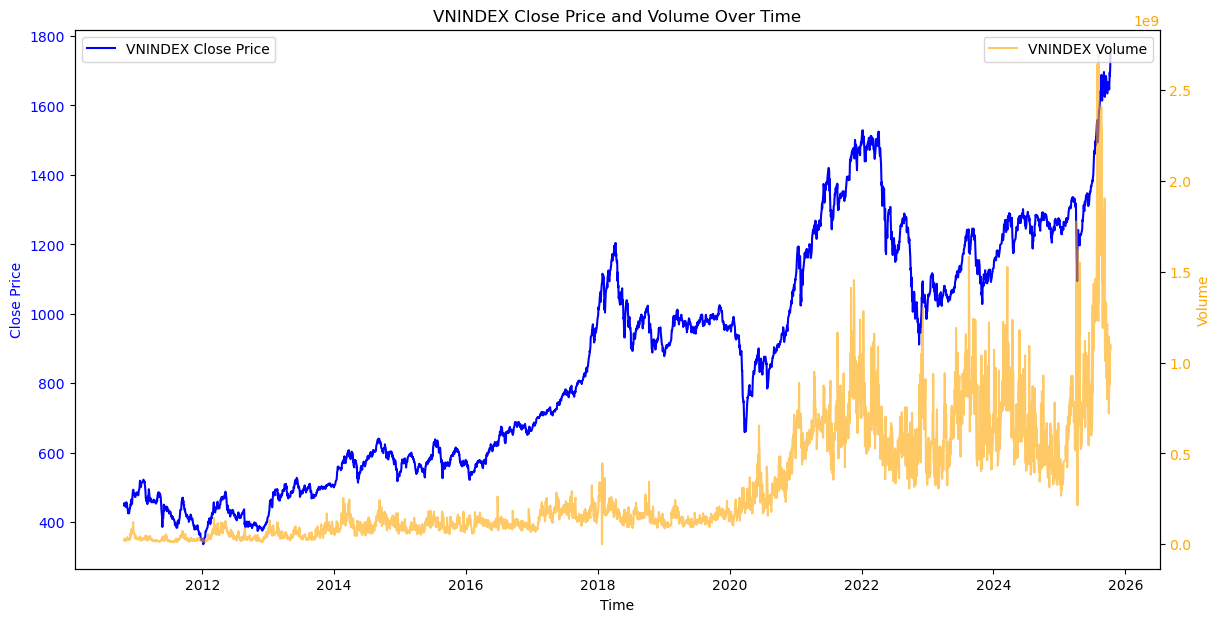

In [ ]:
fig1, ax1 = plt.subplots(figsize=(14,7))
# Plot close price
ax1.plot(df.index, df['close'], label='VNINDEX Close Price', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
# plot volume on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['volume'], label='VNINDEX Volume', color='orange', alpha=0.6)
ax2.set_ylabel('Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.title('VNINDEX Close Price and Volume Over Time')
plt.show()